In [1]:
%matplotlib inline
# %matplotlib ipympl

from IPython.display import clear_output

from datetime import datetime
import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

import random
import string
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D


import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

In [3]:
x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

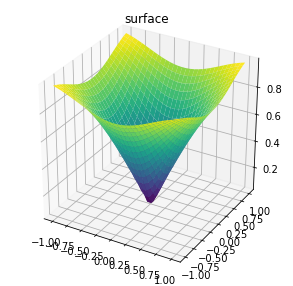

In [4]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)
        
#         self.fc2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
#         nn.init.kaiming_uniform_(self.fc2.weight)
        
#         self.fc3 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
#         nn.init.kaiming_uniform_(self.fc3.weight)

        self.fc_out = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.fc_out.weight) 
    
    def forward(self, x):
        x = self.fc1(x)
        if   (ACTIVATION==0): x = F.relu(x)
        elif (ACTIVATION==1): x = F.leaky_relu(x)
        else                : print("NN ACTIVATION: Error")
#         x = F.leaky_relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.relu(x)
        x = self.fc_out(x)
        return x
    
class DQN(object):
    def __init__(self):
        if(GPU): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device('cpu')
        self.eval_net = Net()
        self.eval_net.to(device)
        self.device = device
        print("Neural net:")
        print(self.eval_net)

  
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.to(torch.device("cpu"))
        actions_value = actions_value.data.numpy()
        return actions_value
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        # input only one sample
        if True:   # greedy
            actions_value = self.eval_net.forward(x)
            actions_value = actions_value.to(torch.device("cpu"))
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        return action

In [6]:
def stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.15
    
    MU_ENP = 0
    SD_ENP = 0.15
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.25
    
    MU_FCAST = 0.42
    SD_FCAST = 0.27
    
    norm_batt, norm_enp, norm_henergy, norm_fcast = s
    
    std_batt    = (norm_batt    - MU_BATT    )/SD_BATT
    std_enp     = (norm_enp     - MU_ENP     )/SD_ENP
    std_henergy = (norm_henergy - MU_HENERGY )/SD_HENERGY
    std_fcast   = (norm_fcast   - MU_FCAST   )/SD_FCAST

    return [std_batt, std_enp, std_henergy, std_fcast]

In [7]:
BMAX          = 10000
HMAX          = 1000
NO_OF_DAYTYPE = 10

In [8]:
# Hyper Parameters
N_ACTIONS           = 10           #no. of duty cycles (0 to 9)
N_STATES            = 4            #number of state space parameter [batt, enp, henergy, fcast]
GPU                 = False
ACTIVATION          = 0            # 0 = RELU, 1 = Leaky RELU
HIDDEN_LAYER        = 50

In [9]:
NAME = "I1"
seed_arg = 4

In [10]:
seedlist = np.array([161, 314, 228, 271828, 230, 4271031, 5526538, 6610165, 9849252, 34534, 73422, 8765])
seed = seedlist[seed_arg]
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [11]:
MODELNAME  = NAME + '_' + str(seed) + '.pt'
print("MODEL NAME: ", MODELNAME)
S_FILENAME = './models/'+ MODELNAME

MODEL NAME:  I1_230.pt


In [12]:
dqn = DQN()
dqn.eval_net.load_state_dict(torch.load(S_FILENAME))
dqn.eval_net.eval()

Neural net:
Net(
  (fc1): Linear(in_features=4, out_features=50, bias=True)
  (fc_out): Linear(in_features=50, out_features=10, bias=True)
)


Net(
  (fc1): Linear(in_features=4, out_features=50, bias=True)
  (fc_out): Linear(in_features=50, out_features=10, bias=True)
)

In [13]:
def get_max_qval(batt, enp, henergy, fcast):
    norm_batt    = batt    /BMAX
    norm_enp     = enp     /BMAX
    norm_henergy = henergy /HMAX
    norm_fcast   = fcast   /(NO_OF_DAYTYPE-1)
    
    state = [norm_batt, norm_enp, norm_henergy, norm_fcast]
    s = stdize(state)
    qval = dqn.get_qvals(s).flatten()
    max_qval = np.max(qval)
       
    return max_qval
    

In [14]:
def get_best_action(batt, enp, henergy, fcast):
    
    norm_batt    = batt    /BMAX
    norm_enp     = enp     /BMAX
    norm_henergy = henergy /HMAX
    norm_fcast   = fcast   /(NO_OF_DAYTYPE-1)
    
    state = [norm_batt, norm_enp, norm_henergy, norm_fcast]
    s = stdize(state)
    greedy_action = dqn.choose_greedy_action(s)
    
    return greedy_action

In [15]:
# # batt    = np.linspace(0, BMAX, 50)
# enp     = np.linspace(-BMAX/2,BMAX/2,50)
# henergy = np.linspace(0, HMAX, 50)

# vec_qval = np.vectorize(get_max_qval)

# X, Y = np.meshgrid(enp, henergy)
# Z = vec_qval(BATT, X, Y, FCAST)

# fig = plt.figure(figsize=(10,10))
# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
# ax.set_title('Greedy Q-values');
# ax.set_xlabel("ENP");
# ax.set_ylabel("Harvested Energy");


In [16]:
BATT    = 0.8 * BMAX
HENERGY = 0.7 * HMAX
ENP     = 0.5*BMAX
FCAST   = 1

In [ ]:

enp     = np.linspace(-BMAX/2,BMAX/2,50)
# batt    = np.linspace(0, BMAX, 50)
henergy = np.linspace(0, HMAX, 50)

vec_best_action = np.vectorize(get_best_action)

X, Y = np.meshgrid(enp, henergy)
Z = vec_best_action(BATT, X, Y, FCAST)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Best Actions');
ax.set_xlabel("ENP");
ax.set_ylabel("Harvested Energy");


In [42]:
QUANTIZATION_LEVEL = 10

In [43]:
batt_s    = np.linspace(0,       BMAX,            QUANTIZATION_LEVEL)
enp_s     = np.linspace(-BMAX/2, BMAX/2,          QUANTIZATION_LEVEL)
henergy_s = np.linspace(0,       HMAX,            QUANTIZATION_LEVEL)
fcast_s   = np.linspace(0,       NO_OF_DAYTYPE-1, NO_OF_DAYTYPE)


In [44]:
B_, E_, H_, F_ = np.meshgrid(batt_s, enp_s, henergy_s, fcast_s)
A = vec_best_action(B_, E_, H_, F_)

In [45]:
A[0,0,0,0]

9

In [36]:
def quantizer(enp):
    enp_state = np.floor((enp + BMAX/2)/QUANTIZATION_STEP)
    return enp_state
    

In [41]:
given enp_value
find which index does enp_value lie in


AttributeError: 'numpy.ndarray' object has no attribute 'find'

In [35]:
enp_s

array([-5000.        , -3888.88888889, -2777.77777778, -1666.66666667,
        -555.55555556,   555.55555556,  1666.66666667,  2777.77777778,
        3888.88888889,  5000.        ])

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
batt    = widgets.IntSlider(min=0,    max=BMAX,  step=50, value=BMAX/2)
enp     = widgets.IntSlider(min=-BMAX,max=BMAX,  step=50, value=0)
henergy = widgets.IntSlider(min=0,    max=HMAX,  step=50, value=HMAX/4)
fcast   = widgets.IntSlider(min=0,max=9,step=1,value=3)
ui = widgets.HBox([batt, enp, henergy, fcast])
fig = plt.figure(figsize=(10,5))

def qmap(batt, enp, henergy, fcast):
    plt.clf()
    print("BATT   :", batt,    end='\t\t')
    print("ENP    :", enp,     end='\t\t')
    print("HENERGY:", henergy, end='\t\t')
    print("FCAST  :", fcast)
    
    norm_batt    = batt    /BMAX
    norm_enp     = enp     /BMAX
    norm_henergy = henergy /HMAX
    norm_fcast   = fcast   /(NO_OF_DAYTYPE-1)
    
    state = [norm_batt, norm_enp, norm_henergy, norm_fcast]
    s = stdize(state)

    qval = dqn.get_qvals(s).flatten()
    norm_qval = qval/np.max(qval)
    plt.bar(np.arange(0,10),norm_qval)
    
    return fcast+3

out = widgets.interactive_output(qmap, {'batt':batt, 'enp':enp, 'henergy':henergy, 'fcast': fcast})
display(ui, out)